# Fraudsters model

This notebook describes the development of the fraudsters detection model and test its accuracy.

## Required Libraries

In [60]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99
import warnings
warnings.simplefilter("ignore")

## Data Reading 

In [5]:
# Reading the customers data set processed in the previous notebook
df_customers  =  pd.read_csv('../data/df_customers_processed.csv')

## Data Analysis

The table of customers has the next variable, each one with its interpretation:
- ID_USER: unique key per customer.
- genero: gender.
- monto: average amount that the customer usually makes in each transaction.
- numero_tc: number of transactions that the customer makes per month.
- hora: Median hour of transactions.
- establecimiento: Most frequent type of place where the customer makes his/her transactions.
- ciudad: Most common city where the customer makes his/her transactions.
- tipo_tc: Most common type of transaction between "Física" and "Virtual".
- linea_tc: Maximum credit line of the customer.
- interes_tc: Maximum credit rate of the customer.
- status_txn:  Most common status of transactions.
- is_prime: If the customer is has a prime membership.
- dcto: Average descount.
- cashback: Average cashback.
- fraude: whether a customer has committed fraud at least once.
- model: Most common device model from where the customer perform his/her transactions.
- device_score:  Most common device score from where the customer perform his/her transactions. 
- os: Most common operating system from where the customer perform his/her transactions.

In [6]:
# Proportion of customers that have committed fraud at least once
df_customers.fraude.sum()/df_customers.shape[0]

0.16875

In [7]:
# Table of customers
df_customers.head()

,ID_USER,genero,monto,numero_tc,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,model,device_score,os
0,0,F,348.532438,2,13.5,Super,Merida,Física,71000,51,Aceptada,False,30.417282,3.624748,False,2020,3,ANDROID
1,1,F,488.113724,7,10.0,Otro,Guadalajara,Física,94000,56,Aceptada,False,17.804483,7.004029,False,2020,3,%%
2,2,F,398.556202,7,10.0,Otro,Toluca,Física,55000,57,Aceptada,False,39.279511,4.092139,False,2020,1,WEB
3,3,F,238.986074,2,15.5,Super,Toluca,Física,62000,34,Aceptada,False,0.000000,2.389861,False,2020,2,ANDROID
4,4,--,277.176524,1,6.0,Restaurante,Merida,Física,83000,37,Aceptada,False,55.435305,2.217412,False,2020,2,WEB


## Model fit 

The chosen model to detect a fraudster was a logistic regression. We trained the regression with all the variables of the customers table as the exogenous variables, except for *ID_USER* and *fraude*. The non numeric variables were transformed to binary variables, for example *genero* became:
- genero_M: 1 if genero is M, 0 otherwise
- genero_F: 1 if genero is F, 0 otherwise
- genero_--: 1 if genero is --, 0 otherwise

Our target variable was *fraude*, so the model estimates the probability of a customer to commit at least one fraud given the described features.

In order to test the model performance we divided the customers table in 2 data sets:
- training set: 80% of the data selected randomly keeping a proportion of fraudsters similar to the complete data set (~17%).
- testing set: the other 20% of the data.

In [24]:
df_train_fraud.head()

,ID_USER,genero,monto,numero_tc,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,model,device_score,os
541,541,M,452.396618,9,7.0,Super,Otro,Física,31000,45,Aceptada,False,18.820136,5.324935,True,2020,3,ANDROID
835,835,F,414.783337,14,11.5,Restaurante,Monterrey,Física,26000,55,Aceptada,False,3.860165,4.581367,True,2020,5,.
875,875,M,317.486782,11,10.0,Otro,Monterrey,Física,81000,61,Aceptada,False,4.432763,4.765859,True,2020,2,ANDROID
2647,2647,M,476.253787,33,11.0,Otro,Otro,Física,88000,61,Aceptada,True,14.537388,5.997181,True,2020,3,.
2610,2610,M,542.870535,9,7.0,Super,Toluca,Física,48000,33,Aceptada,False,11.128258,6.531495,True,2020,3,ANDROID


In [31]:
# Creating the trainig set
df_train_fraud = df_customers.query('fraude == True').sample(frac=0.8, random_state=1)
df_train_no_fraud = df_customers.query('fraude == False').sample(frac=0.8, random_state=1)
df_train = pd.concat([df_train_fraud,df_train_no_fraud]).drop(columns='ID_USER')

In [32]:
# Proportion of customers that have committed fraud at least once in the training set
df_train.fraude.sum()/df_train.shape[0]

0.16875

In [33]:
# Creating the testing set
df_test = df_customers.drop(df_train.index).drop(columns='ID_USER')

In [34]:
# Proportion of customers that have committed fraud at least once in the testing set
df_test.fraude.sum()/df_test.shape[0]

0.16875

In [37]:
# Fitting the model with the training set
df_train_exog = pd.get_dummies(df_train.drop(columns='fraude'),
                          columns = list(set(df_train.drop(columns='fraude').columns)-set(['monto','numero_tc','hora','linea_tc','interes_tc','dcto','cashback','device_score','is_prime'])))
model = Logit(endog = df_train.fraude*1, exog = df_train_exog.astype('float'), missing = 'none')
model_fit = model.fit()

         Current function value: 0.401989
         Iterations: 35


## Model Performance

After observed the ROC curve of true postive and false positives rates, we decided to fix the threshold to detect a fraudster in 20% of propability. After this threshold the rate of false positives keeps near 15% and the true postive rate is above 50%. Our model achives the following metrics:
- Accuracy rate: ~80%, probability of identify rightly a customer between fraudster and no fraudster.
- True positives rate: ~54%, probability of identify a fraudster given the customer actually is a fraudster.
- False postivies rate: ~15%, probability of identify a customer as fraudster and be mistaken.

In [46]:
# Evaluating the model with the testing set
df_test_exog = pd.get_dummies(df_test.drop(columns='fraude'),
                          columns = list(set(df_test.drop(columns='fraude').columns)-set(['monto','numero_tc','hora','linea_tc','interes_tc','dcto','cashback','device_score','is_prime'])))
df_logit_predict = df_test.copy()
df_logit_predict['fraude_prob'] = model_fit.predict(df_test_exog.astype(float))

In [54]:
df_key_rates = pd.DataFrame(metrics.roc_curve(df_logit_predict['fraude'],df_logit_predict['fraude_prob'])).T
df_key_rates.columns = ['%_false_positive','%_true_positive','threshold']

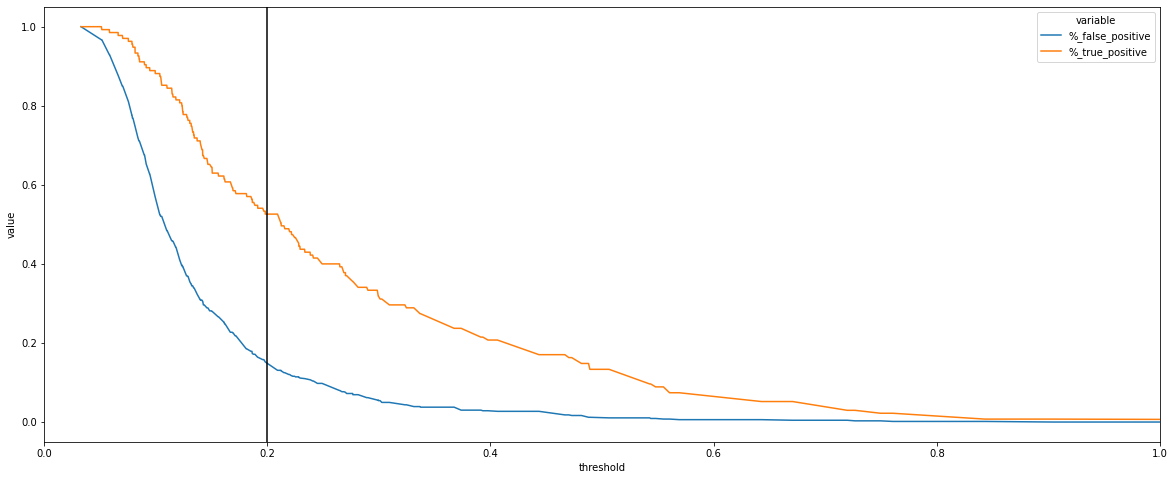

In [65]:
# Ploting the ROC curve
df_key_rates_plot = df_key_rates.melt(id_vars = 'threshold')
plt.figure(figsize=(20,8))
sns.lineplot(data=df_key_rates_plot,x='threshold',y='value',hue='variable')
plt.xlim(0,1)
plt.axvline(x=0.2,color = 'k')
plt.show()

In [69]:
# False postive and True positive rates for our model
df_key_rates.query('threshold >= 0.19 & threshold <= 0.21').mean()

%_false_positive    0.154028
%_true_positive     0.535450
threshold           0.197316
dtype: float64

In [71]:
metrics.accuracy_score(df_logit_predict['fraude'],df_logit_predict['fraude_prob']>0.2)

0.79875

## Model for production 

Our final model has the same structure but is fitted with all the data.

For this model and given a significance level of 10%, the only significant variables are *monto*, *numero_tc* and *dcto*. So we can infer that knowing the frequency of transactions of a customer, its amounts and descounts we could detect if he or she is a fraudster.

On the other hand, by comparing the absolute value of the coefficients of the binary variables, the most relevant non numeric variables are:
1. Most common type of transaction between "Física" and "Virtual".
2. Most frequent type of place where the customer makes his/her transactions.
3. Most common status of transactions.

We omit variable *model* because all the records of our data have the same value, so this variable is behaving as an intercept.

In conclusion, having the data about the transactions of a customer we should be able of detecting if he or she is a potential fraudster regardless of personal features.

In [73]:
df_train = df_customers.drop(columns=['ID_USER','fraude'])
df_train = pd.get_dummies(df_train,
                          columns = list(set(df_train.columns)-set(['monto','numero_tc','hora','linea_tc','interes_tc','dcto','cashback','device_score','is_prime'])))
model = Logit(endog = df_customers.fraude*1, exog = df_train.astype('float'), missing = 'none')
model_fit = model.fit()

Optimization terminated successfully.
         Current function value: 0.398782
         Iterations 13


In [74]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 fraude   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3973
Method:                           MLE   Df Model:                           26
Date:                Fri, 13 Aug 2021   Pseudo R-squ.:                  0.1214
Time:                        18:40:05   Log-Likelihood:                -1595.1
converged:                       True   LL-Null:                       -1815.6
Covariance Type:            nonrobust   LLR p-value:                 5.208e-77
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
monto                          -0.0012      0.001     -1.649      0.099      -0.003       0.000
numero_tc                       0.1206      0.007     16.356      0.000       0.106       0.135
hora                            0.0008      0.011      0.067      0.947      -0.022       0.023
linea_tc                    -3.192e-06    2.1e-06     -1.522      0.128    -7.3e-06     9.2e-07
interes_tc                     -0.0005      0.005     -0.105      0.916      -0.010       0.009
is_prime                       -0.1708      0.138     -1.239      0.215      -0.441       0.099
dcto                            0.0075      0.003      2.694      0.007       0.002       0.013
cashback                        0.0710      0.048      1.492      0.136      -0.022       0.164
device_score                    0.0089      0.032      0.279      0.780      -0.054       0.071
os_%%                          -0.2718   1.37e+07  -1.98e-08      1.000   -2.69e+07    2.69e+07
os_.                           -0.1474   9.86e+06  -1.49e-08      1.000   -1.93e+07    1.93e+07
os_ANDROID                     -0.2462   1.43e+07  -1.72e-08      1.000    -2.8e+07     2.8e+07
os_WEB                         -0.3066   1.21e+07  -2.52e-08      1.000   -2.38e+07    2.38e+07
tipo_tc_Física                 -0.3084   1.57e+07  -1.96e-08      1.000   -3.08e+07    3.08e+07
tipo_tc_Virtual                -0.6636   1.47e+07  -4.51e-08      1.000   -2.88e+07    2.88e+07
status_txn_Aceptada            -0.1048   1.16e+07  -9.05e-09      1.000   -2.27e+07    2.27e+07
status_txn_En proceso          -0.3305   1.19e+07  -2.77e-08      1.000   -2.34e+07    2.34e+07
status_txn_Rechazada           -0.5368   1.23e+07  -4.36e-08      1.000   -2.41e+07    2.41e+07
establecimiento_Abarrotes      -0.1241        nan        nan        nan         nan         nan
establecimiento_Farmacia       -0.5570        nan        nan        nan         nan         nan
establecimiento_MPago          -0.0634        nan        nan        nan         nan         nan
establecimiento_Otro           -0.1207        nan        nan        nan         nan         nan
establecimiento_Restaurante    -0.1302        nan        nan        nan         nan         nan
establecimiento_Super           0.0234        nan        nan        nan         nan         nan
genero_--                      -0.2776   2.43e+07  -1.14e-08      1.000   -4.76e+07    4.76e+07
genero_F                       -0.3180   2.43e+07  -1.31e-08      1.000   -4.76e+07    4.76e+07
genero_M                       -0.3764   2.46e+07  -1.53e-08      1.000   -4.83e+07    4.83e+07
model_2020                     -0.9720   2.22e+07  -4.37e-08      1.000   -4.36e+07    4.36e+07
ciudad_Guadalajara             -0.2154        nan        nan        nan         nan         nan
ciudad_Merida                  -0.1164        nan        nan        nan         nan         nan
ciudad_Monterrey               -0.3620        nan        nan        nan  

In [84]:
pd.DataFrame(np.abs(model_fit.params)).sort_values(by=0,ascending = False)

,0
model_2020,0.972031
tipo_tc_Virtual,0.663637
establecimiento_Farmacia,0.556991
status_txn_Rechazada,0.536809
genero_M,0.376403
ciudad_Monterrey,0.362027
status_txn_En proceso,0.330454
genero_F,0.318044
tipo_tc_Física,0.308392
os_WEB,0.306646


## Model Exportation 

In [ ]:
df_train = df_customers.drop(columns=['ID_USER','fraude'])
df_train = pd.get_dummies(df_train,
                          columns = list(set(df_train.columns)-set(['monto','numero_tc','hora','linea_tc','interes_tc','dcto','cashback','device_score','is_prime'])))
model = Logit(endog = df_customers.fraude*1, exog = df_train.astype('float'), missing = 'none')
model_fit = model.fit()

In [12]:
path_save = "../models/logistic.pkl"
model_fit.save(path_save)